# Numerical Variables Analysis

The following notebook contains analysis made using some of the numerical variables found in the US trending videos found [here](https://www.kaggle.com/datasnaek/youtube-new?select=USvideos.csv). 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

USvideo=pd.read_csv('USvideos.csv')

We want to firstly check which of the variables contain null values.

In [2]:
USvideo.isnull().sum()

video_id                    0
trending_date               0
title                       0
channel_title               0
category_id                 0
publish_time                0
tags                        0
views                       0
likes                       0
dislikes                    0
comment_count               0
thumbnail_link              0
comments_disabled           0
ratings_disabled            0
video_error_or_removed      0
description               570
dtype: int64

Since we are focusing on numerical variables primarily in this analysis, the fact that only descriptions are empty means we can skip cleaning steps for it. However, we may want to measure and compare them at the category level and hence we will map each category id to its corresponding title from the provided JSON and indicate them in the dataframe.

In [3]:
import json

USvideo_cat_json = None

with open('US_category_id.json') as f:
    USvideo_cat_json = json.load(f)

USvideo_cat = {}

for item in USvideo_cat_json["items"]:
    USvideo_cat[int(item["id"])] = item["snippet"]["title"]

In [4]:
USvideo_cat

{1: 'Film & Animation',
 2: 'Autos & Vehicles',
 10: 'Music',
 15: 'Pets & Animals',
 17: 'Sports',
 18: 'Short Movies',
 19: 'Travel & Events',
 20: 'Gaming',
 21: 'Videoblogging',
 22: 'People & Blogs',
 23: 'Comedy',
 24: 'Entertainment',
 25: 'News & Politics',
 26: 'Howto & Style',
 27: 'Education',
 28: 'Science & Technology',
 29: 'Nonprofits & Activism',
 30: 'Movies',
 31: 'Anime/Animation',
 32: 'Action/Adventure',
 33: 'Classics',
 34: 'Comedy',
 35: 'Documentary',
 36: 'Drama',
 37: 'Family',
 38: 'Foreign',
 39: 'Horror',
 40: 'Sci-Fi/Fantasy',
 41: 'Thriller',
 42: 'Shorts',
 43: 'Shows',
 44: 'Trailers'}

In [5]:
for i, row in USvideo.iterrows():
    USvideo.at[i,'category'] = USvideo_cat[USvideo.at[i,'category_id']]

In [6]:
print(USvideo.head())

      video_id trending_date  \
0  2kyS6SvSYSE      17.14.11   
1  1ZAPwfrtAFY      17.14.11   
2  5qpjK5DgCt4      17.14.11   
3  puqaWrEC7tY      17.14.11   
4  d380meD0W0M      17.14.11   

                                               title          channel_title  \
0                 WE WANT TO TALK ABOUT OUR MARRIAGE           CaseyNeistat   
1  The Trump Presidency: Last Week Tonight with J...        LastWeekTonight   
2  Racist Superman | Rudy Mancuso, King Bach & Le...           Rudy Mancuso   
3                   Nickelback Lyrics: Real or Fake?  Good Mythical Morning   
4                           I Dare You: GOING BALD!?               nigahiga   

   category_id              publish_time  \
0           22  2017-11-13T17:13:01.000Z   
1           24  2017-11-13T07:30:00.000Z   
2           23  2017-11-12T19:05:24.000Z   
3           24  2017-11-13T11:00:04.000Z   
4           24  2017-11-12T18:01:41.000Z   

                                                tags    views   lik

As can be seen above, we were able to successfully map our category id's to their corresponding categories. 

## Comparing views and likes

In this analysis, we will be comparing the views and likes of each video to see if we can establish a relationship. We are establishing a correlation at the categorical level. 

In [7]:
for i, row in USvideo.iterrows():
    USvideo.at[i,'view_per_like'] = USvideo.at[i,'views']/USvideo.at[i,'likes']

In [8]:
cat_view_like = pd.DataFrame({
    'category': USvideo['category'],
    'likes': USvideo['likes'],
    'views': USvideo['views'],
    'view_per_like': USvideo['view_per_like']
})

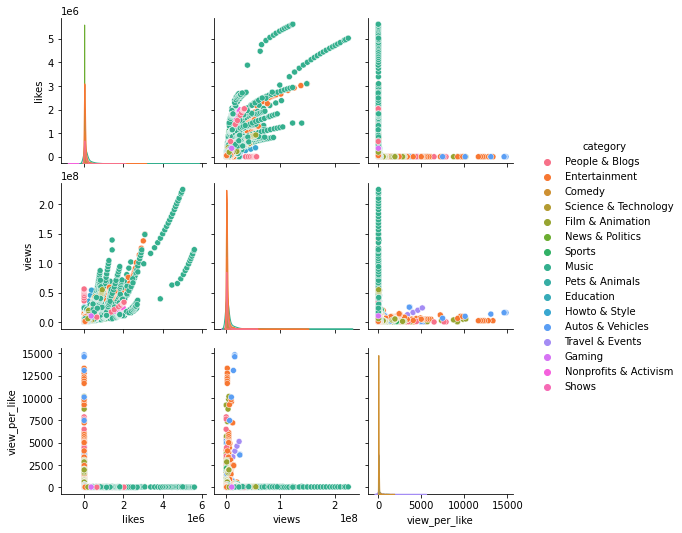

In [9]:
import seaborn as sns

sns.pairplot(cat_view_like, hue='category')

It is worthy to note that we have some datapoints with 0 likes, and to avoid the division error, we add a small number (eg. 1) to it. 

In [10]:
for i,row in cat_view_like.iterrows():
    if cat_view_like.at[i,'likes'] == 0:
        cat_view_like.at[i,'likes'] = 1
    cat_view_like.at[i,'view_per_like'] = cat_view_like.at[i,'views']/cat_view_like.at[i,'likes']

Looking at the plot above, we see that there seems to be an roughly exponential function when plotting likes in the x-axis and views in the y-axis. Thus we will take the log of the views and compare it with the likes to see if there is a correlation. 

In [11]:
from scipy.stats import spearmanr

for category, cat_vals in cat_view_like.groupby('category'):
    log_views = np.array(np.log(cat_vals['views']))
    likes = np.array(cat_vals['likes'])
    corr, _ = spearmanr(log_views, likes)
    print("Correlation in: ", category, " : ", corr)

Correlation in:  Autos & Vehicles  :  0.7110249163287728
Correlation in:  Comedy  :  0.8614386947768155
Correlation in:  Education  :  0.8522696191513189
Correlation in:  Entertainment  :  0.8306897864130138
Correlation in:  Film & Animation  :  0.8496004759077421
Correlation in:  Gaming  :  0.9265330228167135
Correlation in:  Howto & Style  :  0.9223000170894963
Correlation in:  Music  :  0.9294255346752004
Correlation in:  News & Politics  :  0.9059831139514938
Correlation in:  Nonprofits & Activism  :  0.982414084823586
Correlation in:  People & Blogs  :  0.8546277286124683
Correlation in:  Pets & Animals  :  0.8674769406163918
Correlation in:  Science & Technology  :  0.8728174011281229
Correlation in:  Shows  :  0.8785973554576096
Correlation in:  Sports  :  0.8960614733785389
Correlation in:  Travel & Events  :  0.7363215302216196


### Result

From the above result, we can see that all the categories show a correlation of 0.7 or highter for the log_views and likes. This shows that the number of views shows an exponential growth with number of likes. It is interesting to note that the highest correlations are seen in the following categories: Nonprofits & Activism, Music and Gaming. This could mean that there are many passive viewers or the same viewers rewatch the video, which is likely with the later 2 categories. 

## Percentage of comment's disabled

The following analysis sees what percentage of the trending videos have comments disabled in the different categories. This is important because comments allow for an ongoing discussion of the videos and can give a continued interest in it.  

In [12]:
for category, cat_vals in USvideo.groupby('category'):
    print("Category: ", category)
    disabled = cat_vals['comments_disabled'].value_counts().to_dict()
    if True not in disabled.keys():
        disabled[True] = 0
    print("Percentage disabled: ", disabled[True]/(disabled[True]+disabled[False]))

Category:  Autos & Vehicles
Percentage disabled:  0.013020833333333334
Category:  Comedy
Percentage disabled:  0.0005785363031530228
Category:  Education
Percentage disabled:  0.004830917874396135
Category:  Entertainment
Percentage disabled:  0.019670814933761542
Category:  Film & Animation
Percentage disabled:  0.011940298507462687
Category:  Gaming
Percentage disabled:  0.009791921664626682
Category:  Howto & Style
Percentage disabled:  0.002653159671972986
Category:  Music
Percentage disabled:  0.0013906056860321385
Category:  News & Politics
Percentage disabled:  0.06996381182147166
Category:  Nonprofits & Activism
Percentage disabled:  0.07017543859649122
Category:  People & Blogs
Percentage disabled:  0.020560747663551402
Category:  Pets & Animals
Percentage disabled:  0.004347826086956522
Category:  Science & Technology
Percentage disabled:  0.037484381507705125
Category:  Shows
Percentage disabled:  0.0
Category:  Sports
Percentage disabled:  0.012879484820607176
Category:  Tr

### Result

It is interesting to see that Shows and Travel & Events have 0% trending videos with comments disabled. This could be extrapolated to say these categories are reliant on the traffic brought in through comments. The Nonprofits & Activism, News & Politics and Science & Technology categories have the highest percentages. With the first two, it could be intuitively explained as there may be many videos in this category which feature comments disabled, but it interesting to see Technology category to rank amongst them. It may be worth looking into the type of videos produced under this category to dissect what drives their popularity. It should be noted however that all the percentages are relatively small and hence any conclusions must be further investigated to validate them.

In [13]:
videos_per_day = []

for category, cat_vals in USvideo.groupby('trending_date'):
    videos_per_day.append(cat_vals.shape)
    
print("Mean: ", np.mean(videos_per_day))
print("Median: ", np.median(videos_per_day))
print("Stdev: ", np.std(videos_per_day))

Mean:  108.87560975609756
Median:  107.0
Stdev:  90.8769022157749


In [14]:
print(USvideo['category'].value_counts())

Entertainment            9964
Music                    6472
Howto & Style            4146
Comedy                   3457
People & Blogs           3210
News & Politics          2487
Science & Technology     2401
Film & Animation         2345
Sports                   2174
Education                1656
Pets & Animals            920
Gaming                    817
Travel & Events           402
Autos & Vehicles          384
Shows                      57
Nonprofits & Activism      57
Name: category, dtype: int64


In [15]:
print(USvideo.at[0, 'publish_time'][11:-5])

17:13:01


In [16]:
len_times = []

for i, row in USvideo.iterrows():
    len_times.append(len(USvideo.at[i, 'publish_time']))
    
print(set(len_times))

{24}


## Time of publish analysis

The following analysis looks at the time of publishing for the different categories. 

In [17]:
for i, row in USvideo.iterrows():
    hour = int(USvideo.at[i, 'publish_time'][11:13])
    minute = int(USvideo.at[i, 'publish_time'][14:16])
    USvideo.at[i, 'minute_in_day'] = (hour*60)+minute

Category:  Autos & Vehicles
Min:  0.0
Max:  1437.0
Category:  Comedy
Min:  0.0
Max:  1437.0
Category:  Education
Min:  2.0
Max:  1434.0
Category:  Entertainment
Min:  0.0
Max:  1439.0
Category:  Film & Animation
Min:  16.0
Max:  1434.0
Category:  Gaming
Min:  1.0
Max:  1434.0
Category:  Howto & Style
Min:  0.0
Max:  1439.0
Category:  Music
Min:  0.0
Max:  1433.0
Category:  News & Politics
Min:  0.0
Max:  1430.0
Category:  Nonprofits & Activism
Min:  120.0
Max:  1157.0
Category:  People & Blogs
Min:  0.0
Max:  1437.0
Category:  Pets & Animals
Min:  0.0
Max:  1424.0
Category:  Science & Technology
Min:  0.0
Max:  1432.0
Category:  Shows
Min:  76.0
Max:  1261.0
Category:  Sports
Min:  0.0
Max:  1433.0
Category:  Travel & Events
Min:  50.0
Max:  1435.0


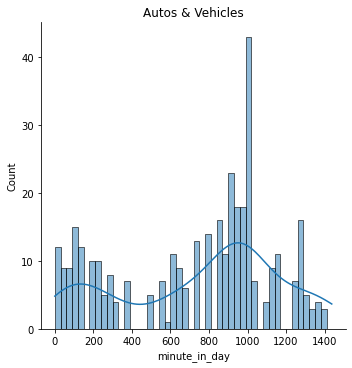

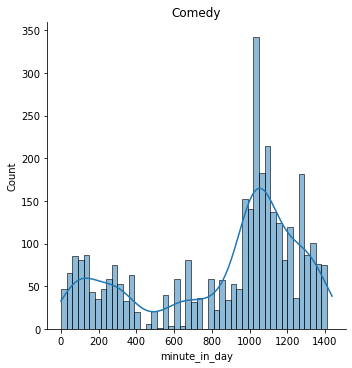

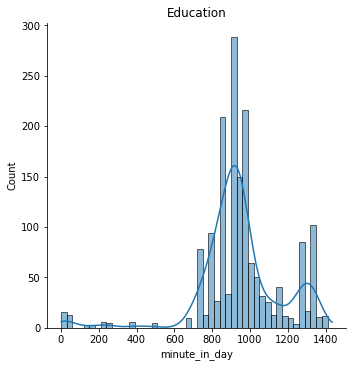

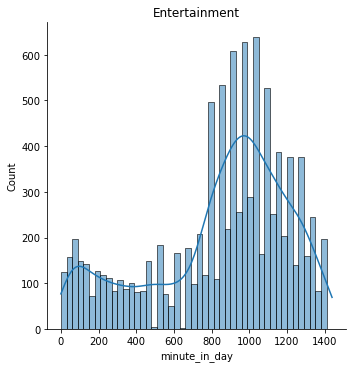

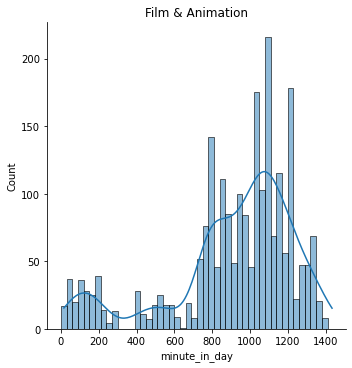

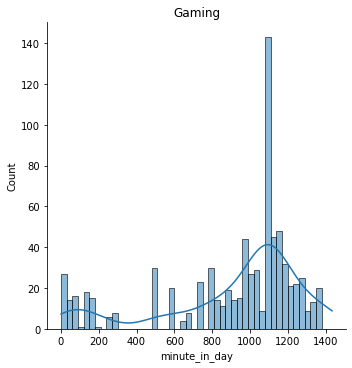

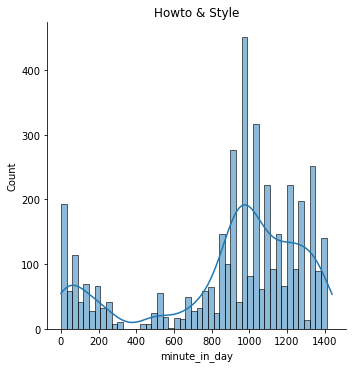

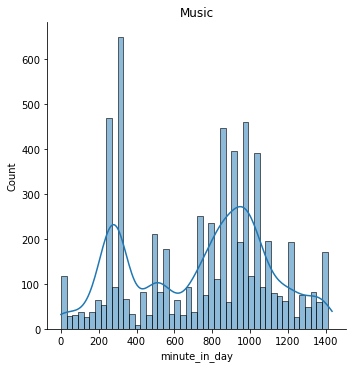

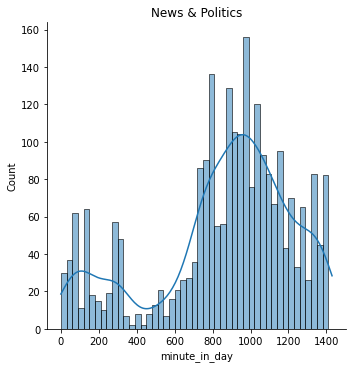

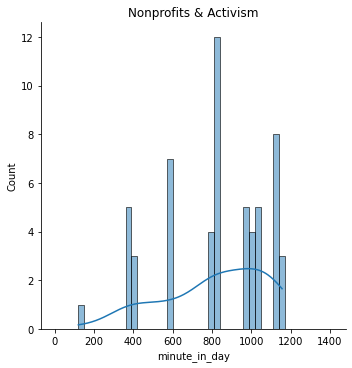

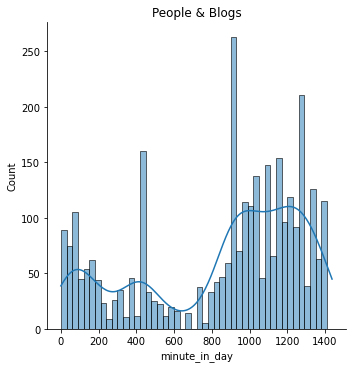

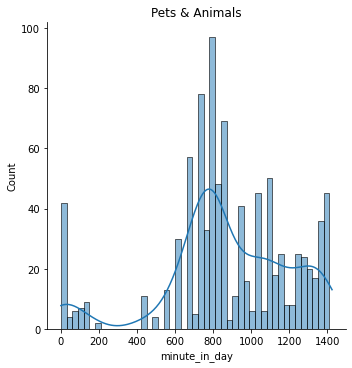

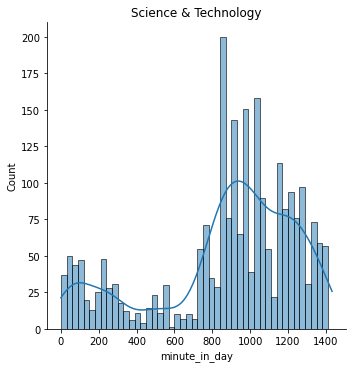

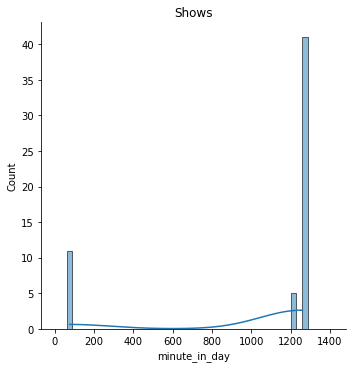

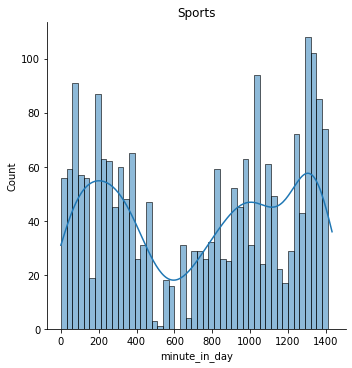

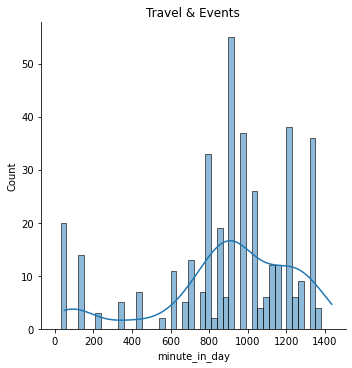

In [25]:
import time

for category, cat_vals in USvideo.groupby('category'):
    print("Category: ", category)
    print("Min: ", np.min(cat_vals['minute_in_day']))
    print("Max: ", np.max(cat_vals['minute_in_day']))
    binwidth = 60
    sns.displot(cat_vals['minute_in_day'], kde=True, bins=range(0,1440,30))
    plt.title(category)

### Result

Looking at the time of publish at the 30 minute granurality, we see patterns in the publish times for some categories. The most prominent ones are as follows: 
* Auto & Vehicles - Most of the trending videos were published between 10am and 5:30pm UTC
* Comedy - Most of the trending videos were published between 4pm and 12am UTC
* Education - Nearly all of the trending videos were published between 11am and 7pm UTC
* Entertainment - More uniform in its distribution but peaks after 10 am UTC. Its is interesting to note that the treanding videos peak between alternate 30 minute blocks.
* Film & Animation - Nearly all of the trending videos are published after 12 noon UTC.
* Gaming - The popular hours are between 1pm UTC and 3am UTC. Its interesting to note that majority of the trending videos were published between 4-4:30 UTC.
* Howto & Style - The trending videos are mostly published between 2pm and 4am UTC. 
* Music - This has two peaks: 12pm UTC-6:30pm UTC, 4am UTC-5:30am UTC
* News & Politics - Nearly all trending videos are published after 12pm UTC.
* Nonprofits & Activism - These are published in 0.5 to 1.5 hour blocks through the day. 
* People & Blogs - Predominantly published after 1pm. 
* Pets & Animals - Peak trending videos between 10am and 2pm.
* Science & Technology - Predominantly published after 12pm.
* Shows - All videos in 3 time zones: 8-8:30pm, 9-9:30pm and 1-1:30am.
* Sports - Spread through the day with peaks from 8pm to 7:30am.
* Trave & Events - Spread through the day with peaks between 10am and 5pm.

## Dislike analysis with other numerical variables

This analyses the dislikes as opposed to other numerical variables such as likes, views and comment_count per category.

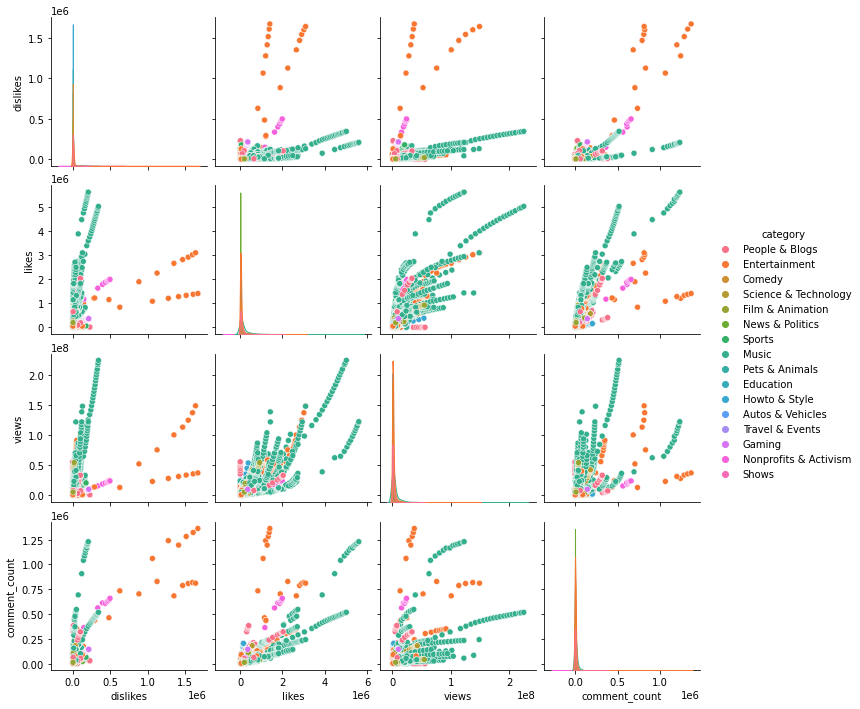

In [26]:
cat_view_dislike = pd.DataFrame({
    'category': USvideo['category'],
    'dislikes': USvideo['dislikes'],
    'likes': USvideo['likes'],
    'views': USvideo['views'],
    'comment_count': USvideo['comment_count']
})

sns.pairplot(cat_view_dislike, hue='category')

The plot shows a linear correlation of likes, a logarithmic correlation with views, and an exponential correlation with comment_count. We'll measure these to validate this analysis. 

In [27]:
for category, cat_vals in cat_view_dislike.groupby('category'):
    log_dislikes = np.array(np.log(cat_vals['dislikes']))
    comments = np.array(cat_vals['comment_count'])
    corr, _ = spearmanr(log_dislikes, comments)
    print("Correlation in: ", category, " : ", corr)

Correlation in:  Autos & Vehicles  :  0.7836306943250232
Correlation in:  Comedy  :  0.7623069477297075
Correlation in:  Education  :  0.8109140167906607
Correlation in:  Entertainment  :  0.8120849794653006
Correlation in:  Film & Animation  :  0.8742013529892192
Correlation in:  Gaming  :  0.7963505661384576
Correlation in:  Howto & Style  :  0.8194341972861414
Correlation in:  Music  :  0.9041933255199924
Correlation in:  News & Politics  :  0.7679489215044751
Correlation in:  Nonprofits & Activism  :  0.9720660918333156
Correlation in:  People & Blogs  :  0.8013128542404444
Correlation in:  Pets & Animals  :  0.8417141635411328
Correlation in:  Science & Technology  :  0.7686685582639395
Correlation in:  Shows  :  -0.04496021005793208
Correlation in:  Sports  :  0.855278436182937
Correlation in:  Travel & Events  :  0.90807790773579


Most category show an agreement with the analysis that the log of dislikes is correlated to the comment_count. It interesting to note that Shows category however, shows a negative correlation. This could be potentially used to decide if a video should be comments disabled or not. 

In [28]:
for category, cat_vals in cat_view_dislike.groupby('category'):
    exp_dislikes = np.array(np.exp(cat_vals['dislikes']))
    views = np.array(cat_vals['views'])
    corr, _ = spearmanr(exp_dislikes, views)
    print("Correlation in: ", category, " : ", corr)

Correlation in:  Autos & Vehicles  :  0.7759339969538922
Correlation in:  Comedy  :  0.7661764615765565
Correlation in:  Education  :  0.7752982700454745
Correlation in:  Entertainment  :  0.7642297628761352
Correlation in:  Film & Animation  :  0.7552933605902774
Correlation in:  Gaming  :  0.7181217362211184
Correlation in:  Howto & Style  :  0.8568732801797371
Correlation in:  Music  :  0.8171442010085139
Correlation in:  News & Politics  :  0.7793210805150083
Correlation in:  Nonprofits & Activism  :  0.9296157777719622
Correlation in:  People & Blogs  :  0.7947728981371059
Correlation in:  Pets & Animals  :  0.875969443125904
Correlation in:  Science & Technology  :  0.8025783613442208
Correlation in:  Shows  :  0.7534761647132111
Correlation in:  Sports  :  0.8628279891833992
Correlation in:  Travel & Events  :  0.7717546166367423


We are able to validate that the exponential of dislikes is correlated to the views. This combined with the fact we saw the same above for likes could mean either that likes and dislikes are linearly related or that views could potentially be driving the likes and dislikes. 

In [29]:
for category, cat_vals in cat_view_dislike.groupby('category'):
    dislikes = np.array(cat_vals['dislikes'])
    likes = np.array(cat_vals['likes'])
    corr, _ = spearmanr(dislikes, likes)
    print("Correlation in: ", category, " : ", corr)

Correlation in:  Autos & Vehicles  :  0.8008926921385331
Correlation in:  Comedy  :  0.7857146660742099
Correlation in:  Education  :  0.6984954524732737
Correlation in:  Entertainment  :  0.7461901236576399
Correlation in:  Film & Animation  :  0.8306074932720411
Correlation in:  Gaming  :  0.8733034295117442
Correlation in:  Howto & Style  :  0.8319418633945298
Correlation in:  Music  :  0.8938738182697865
Correlation in:  News & Politics  :  0.7827548103754635
Correlation in:  Nonprofits & Activism  :  0.9398252079561319
Correlation in:  People & Blogs  :  0.7663547254522928
Correlation in:  Pets & Animals  :  0.8044862827879755
Correlation in:  Science & Technology  :  0.8294266439395673
Correlation in:  Shows  :  0.4850419755208501
Correlation in:  Sports  :  0.8221154641808912
Correlation in:  Travel & Events  :  0.7683174260824316


Except for Shows, all other categories show a fairly strong correlation. Shows however are leaning towards a neutral disposition on the likes and dislikes. 